In [3]:
!pip install -U tabpfn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.8/160.8 kB 7.2 MB/s eta 0:00:00


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tabpfn import TabPFNClassifier

In [5]:
# 데이터 받아오기, 파일명과 컬럼
train = pd.read_csv("df.csv")
X = train.drop(columns=["support_needs"])
y = train["support_needs"]

# TabPFN v2는 수치/범주형/결측치 처리를 내부에서 지원 → 원핫 인코딩 불필요
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

clf = TabPFNClassifier(device="cuda", ignore_pretraining_limits=True)   # GPU가 없다면 device="cpu"
clf.fit(X_train, y_train)

pred = clf.predict(X_val)
print("F1-macro:", f1_score(y_val, pred, average="macro"))

tabpfn-v2-classifier-finetuned-zk73skhh.(…):   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

F1-macro: 0.39158266757598287


In [6]:
test = pd.read_csv("test_prep.csv")
test_pred = clf.predict(test)

sub = pd.DataFrame({
    "id": [f"TEST_{i:05d}" for i in range(len(test_pred))],
    "support_needs": test_pred
})
sub.to_csv("submission.csv", index=False)

=== TabPFN v2 샘플링 기반 앙상블 (클래스 불균형 해결) ===

1. 데이터 로딩...
Train 데이터 크기: (30858, 10)
Test 데이터 크기: (13225, 9)
클래스 분포: Counter({np.int64(0): 14297, np.int64(1): 8297, np.int64(2): 8264})
클래스 비율: {'0': np.float64(0.4633158338194309), '1': np.float64(0.2688767904595243), '2': np.float64(0.2678073757210448)}
학습용 데이터: 26229개
검증용 데이터: 4629개

2. 다양한 샘플링 전략 테스트...

--- BALANCED 전략 테스트 ---
샘플 크기: 9999
클래스 분포: {np.int64(0): 3333, np.int64(1): 3333, np.int64(2): 3333}
클래스 비율: {'0': 0.3333333333333333, '1': 0.3333333333333333, '2': 0.3333333333333333}
F1-macro: 0.4754
클래스별 F1: {'0': np.float64(0.5399723374827109), '1': np.float64(0.3547579298831386), '2': np.float64(0.5315676008623345)}

--- WEIGHTED 전략 테스트 ---
샘플 크기: 10000
클래스 분포: {np.int64(0): 4000, np.int64(1): 3500, np.int64(2): 2500}
클래스 비율: {'0': 0.4, '1': 0.35, '2': 0.25}
F1-macro: 0.4633
클래스별 F1: {'0': np.float64(0.5762195121951219), '1': np.float64(0.34269885239414327), '2': np.float64(0.4708407871198569)}

--- SMOTE 전략 테스트 ---
샘플 크기: 9999
클래

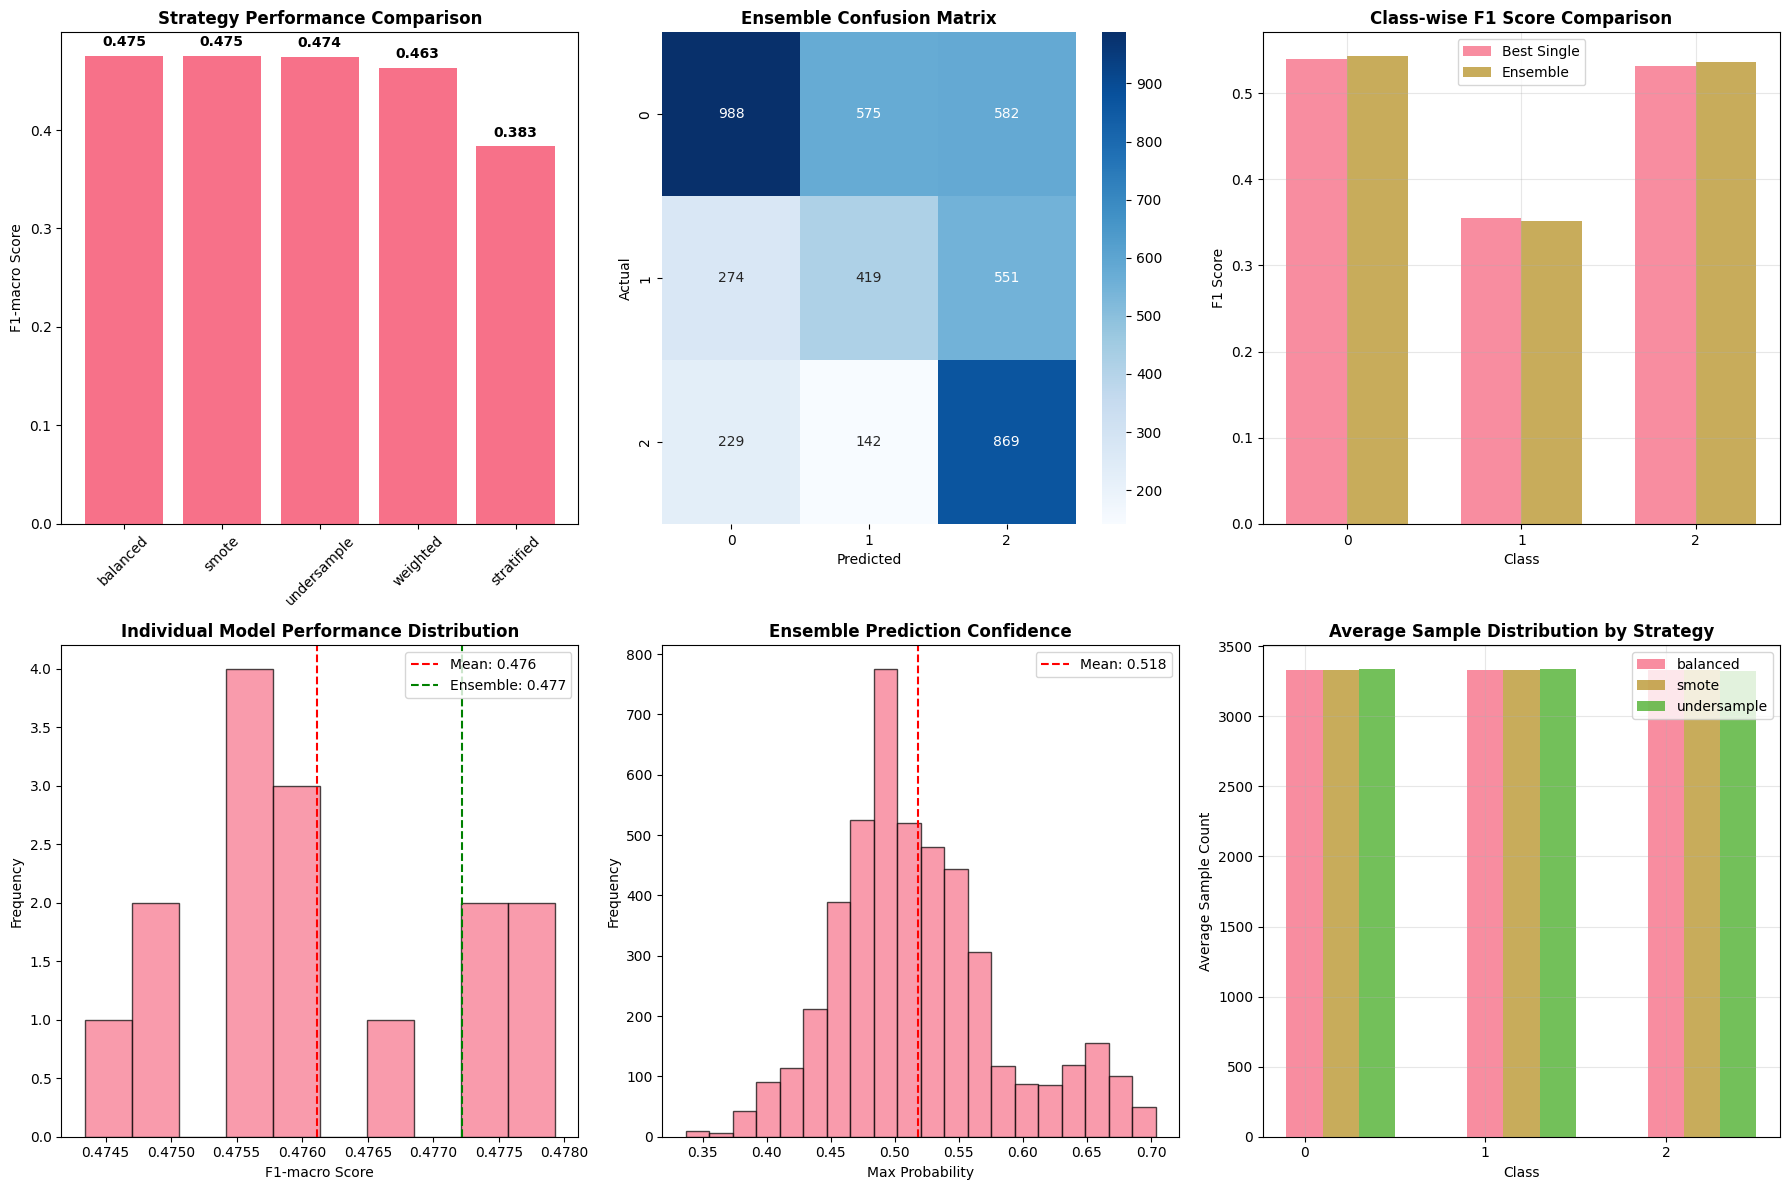


7. 최종 테스트 예측...
샘플링 앙상블 제출 파일 저장: submission_sampling_ensemble.csv

테스트 예측 분포: {np.int64(2): 5750, np.int64(1): 3121, np.int64(0): 4354}
테스트 예측 비율: {np.int64(0): 0.3292249527410208, np.int64(1): 0.23599243856332702, np.int64(2): 0.43478260869565216}

샘플링 기반 앙상블 최종 성능 요약
최고 단일 전략 (balanced): F1-macro = 0.4754
앙상블 모델: F1-macro = 0.4772
성능 개선: 0.0018 (+0.37%)

클래스별 성능 개선:
  클래스 0: 0.5400 → 0.5435 (+0.0035)
  클래스 1: 0.3548 → 0.3521 (-0.0027)
  클래스 2: 0.5316 → 0.5361 (+0.0045)

사용된 모델 수: 15
평균 모델 성능: 0.4761 (±0.0011)

8. 추가 개선 방안:
1. 임계값 조정: 각 클래스별로 다른 예측 임계값 설정
2. 가중치 조정: 클래스별 오분류 비용을 고려한 가중치 적용
3. 후처리 규칙: 도메인 지식을 활용한 예측 후처리
4. 특성 엔지니어링: 클래스 구분에 도움되는 새로운 특성 생성
5. 하이브리드 앙상블: TabPFN + XGBoost/LightGBM 조합


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tabpfn import TabPFNClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.style.use('default')
sns.set_palette("husl")

print("=== TabPFN v2 샘플링 기반 앙상블 (클래스 불균형 해결) ===\n")

# 1. 데이터 로드
print("1. 데이터 로딩...")
train = pd.read_csv("df.csv")
test = pd.read_csv("test_prep.csv")

print(f"Train 데이터 크기: {train.shape}")
print(f"Test 데이터 크기: {test.shape}")

X = train.drop(columns=["support_needs"])
y = train["support_needs"]

# 타겟 변수 레이블 인코딩
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = [str(cls) for cls in le.classes_]

print(f"클래스 분포: {Counter(y_encoded)}")
print(f"클래스 비율: {dict(zip(class_names, np.bincount(y_encoded) / len(y_encoded)))}")

# 검증 세트 분할 (전체 데이터에서)
X_temp, X_val, y_temp, y_val = train_test_split(
    X, y_encoded,
    stratify=y_encoded,
    test_size=0.15,  # 검증용으로 15% 할당
    random_state=42
)

print(f"학습용 데이터: {X_temp.shape[0]}개")
print(f"검증용 데이터: {X_val.shape[0]}개")

# 2. 다양한 샘플링 전략 정의
def create_balanced_sample(X, y, sample_size=10000, strategy='balanced', random_state=42):
    """
    다양한 전략으로 균형잡힌 샘플 생성

    strategy:
    - 'balanced': 각 클래스를 동일하게 샘플링
    - 'weighted': 클래스 비율을 조정하되 완전히 균등하지는 않게
    - 'smote': SMOTE 오버샘플링 적용
    - 'undersample': 다수 클래스 언더샘플링
    - 'stratified': 원본 비율을 유지하되 샘플 크기만 줄임
    """
    np.random.seed(random_state)

    if strategy == 'balanced':
        # 각 클래스를 동일하게 샘플링
        samples_per_class = sample_size // len(np.unique(y))

        balanced_indices = []
        for cls in np.unique(y):
            cls_indices = np.where(y == cls)[0]
            if len(cls_indices) >= samples_per_class:
                sampled_indices = np.random.choice(cls_indices, samples_per_class, replace=False)
            else:
                # 클래스 샘플이 부족하면 복원 추출
                sampled_indices = np.random.choice(cls_indices, samples_per_class, replace=True)
            balanced_indices.extend(sampled_indices)

        balanced_indices = np.array(balanced_indices)
        return X.iloc[balanced_indices], y[balanced_indices]

    elif strategy == 'weighted':
        # 클래스 0: 40%, 클래스 1: 35%, 클래스 2: 25% 비율로 조정
        target_ratios = {0: 0.4, 1: 0.35, 2: 0.25}

        weighted_indices = []
        for cls, ratio in target_ratios.items():
            target_count = int(sample_size * ratio)
            cls_indices = np.where(y == cls)[0]
            if len(cls_indices) >= target_count:
                sampled_indices = np.random.choice(cls_indices, target_count, replace=False)
            else:
                sampled_indices = np.random.choice(cls_indices, target_count, replace=True)
            weighted_indices.extend(sampled_indices)

        weighted_indices = np.array(weighted_indices)
        return X.iloc[weighted_indices], y[weighted_indices]

    elif strategy == 'smote':
        # 원본에서 일정 크기 샘플링 후 SMOTE 적용
        if len(y) > sample_size * 0.7:
            sample_indices = np.random.choice(len(y), int(sample_size * 0.7), replace=False)
            X_sample = X.iloc[sample_indices]
            y_sample = y[sample_indices]
        else:
            X_sample, y_sample = X, y

        smote = SMOTE(random_state=random_state, k_neighbors=3)
        try:
            X_resampled, y_resampled = smote.fit_resample(X_sample, y_sample)
            # 샘플 크기 조정
            if len(y_resampled) > sample_size:
                indices = np.random.choice(len(y_resampled), sample_size, replace=False)
                X_resampled = X_resampled.iloc[indices] if hasattr(X_resampled, 'iloc') else pd.DataFrame(X_resampled).iloc[indices]
                y_resampled = y_resampled[indices]
            return X_resampled, y_resampled
        except:
            # SMOTE 실패시 balanced 전략으로 폴백
            return create_balanced_sample(X, y, sample_size, 'balanced', random_state)

    elif strategy == 'undersample':
        # 다수 클래스 언더샘플링
        undersampler = RandomUnderSampler(random_state=random_state)
        try:
            X_resampled, y_resampled = undersampler.fit_resample(X, y)
            # 샘플 크기 조정
            if len(y_resampled) > sample_size:
                indices = np.random.choice(len(y_resampled), sample_size, replace=False)
                X_resampled = X_resampled.iloc[indices] if hasattr(X_resampled, 'iloc') else pd.DataFrame(X_resampled).iloc[indices]
                y_resampled = y_resampled[indices]
            elif len(y_resampled) < sample_size:
                # 부족하면 복원 추출로 보충
                additional_needed = sample_size - len(y_resampled)
                additional_indices = np.random.choice(len(y_resampled), additional_needed, replace=True)
                if hasattr(X_resampled, 'iloc'):
                    X_additional = X_resampled.iloc[additional_indices]
                    X_resampled = pd.concat([X_resampled, X_additional])
                else:
                    X_resampled = pd.DataFrame(X_resampled)
                    X_additional = X_resampled.iloc[additional_indices]
                    X_resampled = pd.concat([X_resampled, X_additional])
                y_resampled = np.concatenate([y_resampled, y_resampled[additional_indices]])

            return X_resampled, y_resampled
        except:
            return create_balanced_sample(X, y, sample_size, 'balanced', random_state)

    elif strategy == 'stratified':
        # 원본 비율 유지하며 샘플링
        if len(y) <= sample_size:
            return X, y

        # 계층화 샘플링
        sss = StratifiedShuffleSplit(n_splits=1, train_size=sample_size, random_state=random_state)
        train_idx, _ = next(sss.split(X, y))
        return X.iloc[train_idx], y[train_idx]

    else:
        raise ValueError(f"Unknown strategy: {strategy}")

# 3. 샘플링 전략별 성능 테스트
print("\n2. 다양한 샘플링 전략 테스트...")

strategies = ['balanced', 'weighted', 'smote', 'undersample', 'stratified']
strategy_results = {}

sample_size = 10000  # TabPFN v2 최적 크기

for strategy in strategies:
    print(f"\n--- {strategy.upper()} 전략 테스트 ---")

    try:
        # 샘플링
        X_sample, y_sample = create_balanced_sample(X_temp, y_temp, sample_size, strategy, random_state=42)

        print(f"샘플 크기: {len(y_sample)}")
        sample_dist = Counter(y_sample)
        print(f"클래스 분포: {dict(sample_dist)}")
        print(f"클래스 비율: {dict(zip(class_names, [sample_dist[i]/len(y_sample) for i in range(len(class_names))]))}")

        # TabPFN 모델 학습
        clf = TabPFNClassifier(device="cuda", ignore_pretraining_limits=True)
        clf.fit(X_sample, y_sample)

        # 검증
        y_pred = clf.predict(X_val)
        f1_macro = f1_score(y_val, y_pred, average="macro")
        f1_per_class = f1_score(y_val, y_pred, average=None)

        print(f"F1-macro: {f1_macro:.4f}")
        print(f"클래스별 F1: {dict(zip(class_names, f1_per_class))}")

        strategy_results[strategy] = {
            'f1_macro': f1_macro,
            'f1_per_class': f1_per_class,
            'sample_dist': sample_dist,
            'model': clf
        }

    except Exception as e:
        print(f"에러 발생: {e}")
        strategy_results[strategy] = None

# 4. 최고 성능 전략들로 앙상블 구성
print("\n3. 상위 전략들로 앙상블 구성...")

# 성능 순으로 정렬
valid_strategies = {k: v for k, v in strategy_results.items() if v is not None}
sorted_strategies = sorted(valid_strategies.items(), key=lambda x: x[1]['f1_macro'], reverse=True)

print("전략별 성능 순위:")
for i, (strategy, result) in enumerate(sorted_strategies):
    print(f"{i+1}. {strategy}: F1-macro = {result['f1_macro']:.4f}")

# 상위 3개 전략 선택
top_strategies = [item[0] for item in sorted_strategies[:3]]
print(f"\n앙상블에 사용할 전략: {top_strategies}")

# 5. 다중 시드로 앙상블 모델 구성
print("\n4. 다중 시드 앙상블 학습...")

ensemble_models = []
ensemble_info = []
n_seeds = 5

for strategy in top_strategies:
    for seed in range(42, 42 + n_seeds):
        try:
            X_sample, y_sample = create_balanced_sample(X_temp, y_temp, sample_size, strategy, random_state=seed)

            clf = TabPFNClassifier(device="cuda", ignore_pretraining_limits=True)
            clf.fit(X_sample, y_sample)

            # 검증 성능 체크
            y_pred = clf.predict(X_val)
            f1_macro = f1_score(y_val, y_pred, average="macro")

            ensemble_models.append(clf)
            ensemble_info.append({
                'strategy': strategy,
                'seed': seed,
                'f1_macro': f1_macro,
                'sample_dist': Counter(y_sample)
            })

            print(f"{strategy}-seed{seed}: F1-macro = {f1_macro:.4f}")

        except Exception as e:
            print(f"{strategy}-seed{seed} 실패: {e}")

print(f"\n총 {len(ensemble_models)}개 모델로 앙상블 구성")

# 6. 앙상블 예측
print("\n5. 앙상블 예측 수행...")

if len(ensemble_models) > 0:
    # 각 모델의 예측 확률 수집
    ensemble_probas = []
    for i, clf in enumerate(ensemble_models):
        try:
            proba = clf.predict_proba(X_val)
            ensemble_probas.append(proba)
        except:
            print(f"모델 {i} 예측 실패")

    if len(ensemble_probas) > 0:
        # 확률 평균으로 최종 예측
        ensemble_proba_avg = np.mean(ensemble_probas, axis=0)
        ensemble_pred_final = np.argmax(ensemble_proba_avg, axis=1)

        # 성능 평가
        f1_ensemble = f1_score(y_val, ensemble_pred_final, average="macro")
        f1_ensemble_per_class = f1_score(y_val, ensemble_pred_final, average=None)

        print(f"앙상블 F1-macro: {f1_ensemble:.4f}")
        print(f"앙상블 클래스별 F1: {dict(zip(class_names, f1_ensemble_per_class))}")

        # 7. 상세 분석 및 시각화
        print("\n6. 상세 분석...")

        # 분류 리포트
        print("\n앙상블 분류 리포트:")
        print(classification_report(y_val, ensemble_pred_final, target_names=class_names, digits=4))

        # 시각화
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # (1) 전략별 성능 비교
        strategy_names = []
        strategy_scores = []
        for strategy, result in sorted_strategies:
            strategy_names.append(strategy)
            strategy_scores.append(result['f1_macro'])

        axes[0, 0].bar(strategy_names, strategy_scores)
        axes[0, 0].set_title('Strategy Performance Comparison', fontweight='bold')
        axes[0, 0].set_ylabel('F1-macro Score')
        axes[0, 0].tick_params(axis='x', rotation=45)
        for i, score in enumerate(strategy_scores):
            axes[0, 0].text(i, score + 0.01, f'{score:.3f}', ha='center', fontweight='bold')

        # (2) 앙상블 혼동 행렬
        cm = confusion_matrix(y_val, ensemble_pred_final)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1],
                    xticklabels=class_names, yticklabels=class_names)
        axes[0, 1].set_title('Ensemble Confusion Matrix', fontweight='bold')
        axes[0, 1].set_xlabel('Predicted')
        axes[0, 1].set_ylabel('Actual')

        # (3) 클래스별 F1 스코어 비교 (단일 최고 vs 앙상블)
        best_single_f1 = sorted_strategies[0][1]['f1_per_class']

        x_pos = np.arange(len(class_names))
        width = 0.35
        axes[0, 2].bar(x_pos - width/2, best_single_f1, width, label='Best Single', alpha=0.8)
        axes[0, 2].bar(x_pos + width/2, f1_ensemble_per_class, width, label='Ensemble', alpha=0.8)
        axes[0, 2].set_title('Class-wise F1 Score Comparison', fontweight='bold')
        axes[0, 2].set_xlabel('Class')
        axes[0, 2].set_ylabel('F1 Score')
        axes[0, 2].set_xticks(x_pos)
        axes[0, 2].set_xticklabels(class_names)
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)

        # (4) 모델별 성능 분포
        model_scores = [info['f1_macro'] for info in ensemble_info]
        axes[1, 0].hist(model_scores, bins=10, alpha=0.7, edgecolor='black')
        axes[1, 0].axvline(np.mean(model_scores), color='red', linestyle='--',
                          label=f'Mean: {np.mean(model_scores):.3f}')
        axes[1, 0].axvline(f1_ensemble, color='green', linestyle='--',
                          label=f'Ensemble: {f1_ensemble:.3f}')
        axes[1, 0].set_title('Individual Model Performance Distribution', fontweight='bold')
        axes[1, 0].set_xlabel('F1-macro Score')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].legend()

        # (5) 예측 확신도 분포
        max_proba = np.max(ensemble_proba_avg, axis=1)
        axes[1, 1].hist(max_proba, bins=20, alpha=0.7, edgecolor='black')
        axes[1, 1].set_title('Ensemble Prediction Confidence', fontweight='bold')
        axes[1, 1].set_xlabel('Max Probability')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].axvline(np.mean(max_proba), color='red', linestyle='--',
                          label=f'Mean: {np.mean(max_proba):.3f}')
        axes[1, 1].legend()

        # (6) 전략별 샘플 분포
        strategy_data = {}
        for info in ensemble_info:
            strategy = info['strategy']
            if strategy not in strategy_data:
                strategy_data[strategy] = {cls: [] for cls in range(len(class_names))}
            for cls in range(len(class_names)):
                strategy_data[strategy][cls].append(info['sample_dist'].get(cls, 0))

        # 전략별 평균 클래스 분포
        for i, (strategy, data) in enumerate(strategy_data.items()):
            avg_dist = [np.mean(data[cls]) for cls in range(len(class_names))]
            axes[1, 2].bar([x + i*0.2 for x in range(len(class_names))], avg_dist,
                          width=0.2, label=strategy, alpha=0.8)

        axes[1, 2].set_title('Average Sample Distribution by Strategy', fontweight='bold')
        axes[1, 2].set_xlabel('Class')
        axes[1, 2].set_ylabel('Average Sample Count')
        axes[1, 2].set_xticks(range(len(class_names)))
        axes[1, 2].set_xticklabels(class_names)
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # 8. 테스트 예측
        print("\n7. 최종 테스트 예측...")

        test_probas = []
        for clf in ensemble_models:
            try:
                test_proba = clf.predict_proba(test)
                test_probas.append(test_proba)
            except Exception as e:
                print(f"테스트 예측 실패: {e}")

        if len(test_probas) > 0:
            test_proba_avg = np.mean(test_probas, axis=0)
            test_pred_final = np.argmax(test_proba_avg, axis=1)

            # 원래 레이블로 변환
            test_pred_decoded = le.inverse_transform(test_pred_final)

            # 제출 파일 생성
            sub = pd.DataFrame({
                "id": [f"TEST_{i:05d}" for i in range(len(test_pred_decoded))],
                "support_needs": test_pred_decoded
            })
            sub.to_csv("submission_sampling_ensemble.csv", index=False)
            print("샘플링 앙상블 제출 파일 저장: submission_sampling_ensemble.csv")

            # 테스트 예측 분포 확인
            test_pred_dist = Counter(test_pred_decoded)
            print(f"\n테스트 예측 분포: {dict(test_pred_dist)}")
            print(f"테스트 예측 비율: {dict(zip(le.classes_, [test_pred_dist[cls]/len(test_pred_decoded) for cls in le.classes_]))}")

        # 9. 최종 성능 요약
        print("\n" + "="*60)
        print("샘플링 기반 앙상블 최종 성능 요약")
        print("="*60)

        print(f"최고 단일 전략 ({sorted_strategies[0][0]}): F1-macro = {sorted_strategies[0][1]['f1_macro']:.4f}")
        print(f"앙상블 모델: F1-macro = {f1_ensemble:.4f}")
        improvement = f1_ensemble - sorted_strategies[0][1]['f1_macro']
        print(f"성능 개선: {improvement:.4f} ({improvement/sorted_strategies[0][1]['f1_macro']*100:+.2f}%)")

        print(f"\n클래스별 성능 개선:")
        for i, class_name in enumerate(class_names):
            single_f1 = sorted_strategies[0][1]['f1_per_class'][i]
            ensemble_f1 = f1_ensemble_per_class[i]
            improvement = ensemble_f1 - single_f1
            print(f"  클래스 {class_name}: {single_f1:.4f} → {ensemble_f1:.4f} ({improvement:+.4f})")

        print(f"\n사용된 모델 수: {len(ensemble_models)}")
        print(f"평균 모델 성능: {np.mean(model_scores):.4f} (±{np.std(model_scores):.4f})")
        print("="*60)

    else:
        print("앙상블 예측 실패 - 유효한 예측 결과가 없습니다.")
else:
    print("앙상블 모델 구성 실패 - 유효한 모델이 없습니다.")

# 10. 추가 개선 방안 제시
print("\n8. 추가 개선 방안:")
print("1. 임계값 조정: 각 클래스별로 다른 예측 임계값 설정")
print("2. 가중치 조정: 클래스별 오분류 비용을 고려한 가중치 적용")
print("3. 후처리 규칙: 도메인 지식을 활용한 예측 후처리")
print("4. 특성 엔지니어링: 클래스 구분에 도움되는 새로운 특성 생성")
print("5. 하이브리드 앙상블: TabPFN + XGBoost/LightGBM 조합")

=== TabPFN v2 Enhanced Sampling Ensemble with Bagging ===

1. 데이터 로딩...
Train 데이터 크기: (30858, 10)
Test 데이터 크기: (13225, 9)
클래스 분포: Counter({np.int64(0): 14297, np.int64(1): 8297, np.int64(2): 8264})
클래스 비율: {'0': np.float64(0.4633158338194309), '1': np.float64(0.2688767904595243), '2': np.float64(0.2678073757210448)}
학습용 데이터: 26229개
검증용 데이터: 4629개

2. 다양한 샘플링 전략 테스트...
테스트할 샘플 크기: [7000, 8000]

=== 샘플 크기 7000개로 전략 테스트 ===

--- BALANCED 전략 테스트 (샘플: 7000) ---
샘플 크기: 6999
클래스 분포: {np.int64(0): 2333, np.int64(1): 2333, np.int64(2): 2333}
클래스 비율: {'0': 0.3333333333333333, '1': 0.3333333333333333, '2': 0.3333333333333333}
F1-macro: 0.4729
클래스별 F1: {'0': np.float64(0.5555555555555556), '1': np.float64(0.33889602053915274), '2': np.float64(0.5243940824677369)}

--- WEIGHTED 전략 테스트 (샘플: 7000) ---
샘플 크기: 7000
클래스 분포: {np.int64(0): 2800, np.int64(1): 2450, np.int64(2): 1750}
클래스 비율: {'0': 0.4, '1': 0.35, '2': 0.25}
F1-macro: 0.4580
클래스별 F1: {'0': np.float64(0.6041568256967407), '1': np.float64(0.3

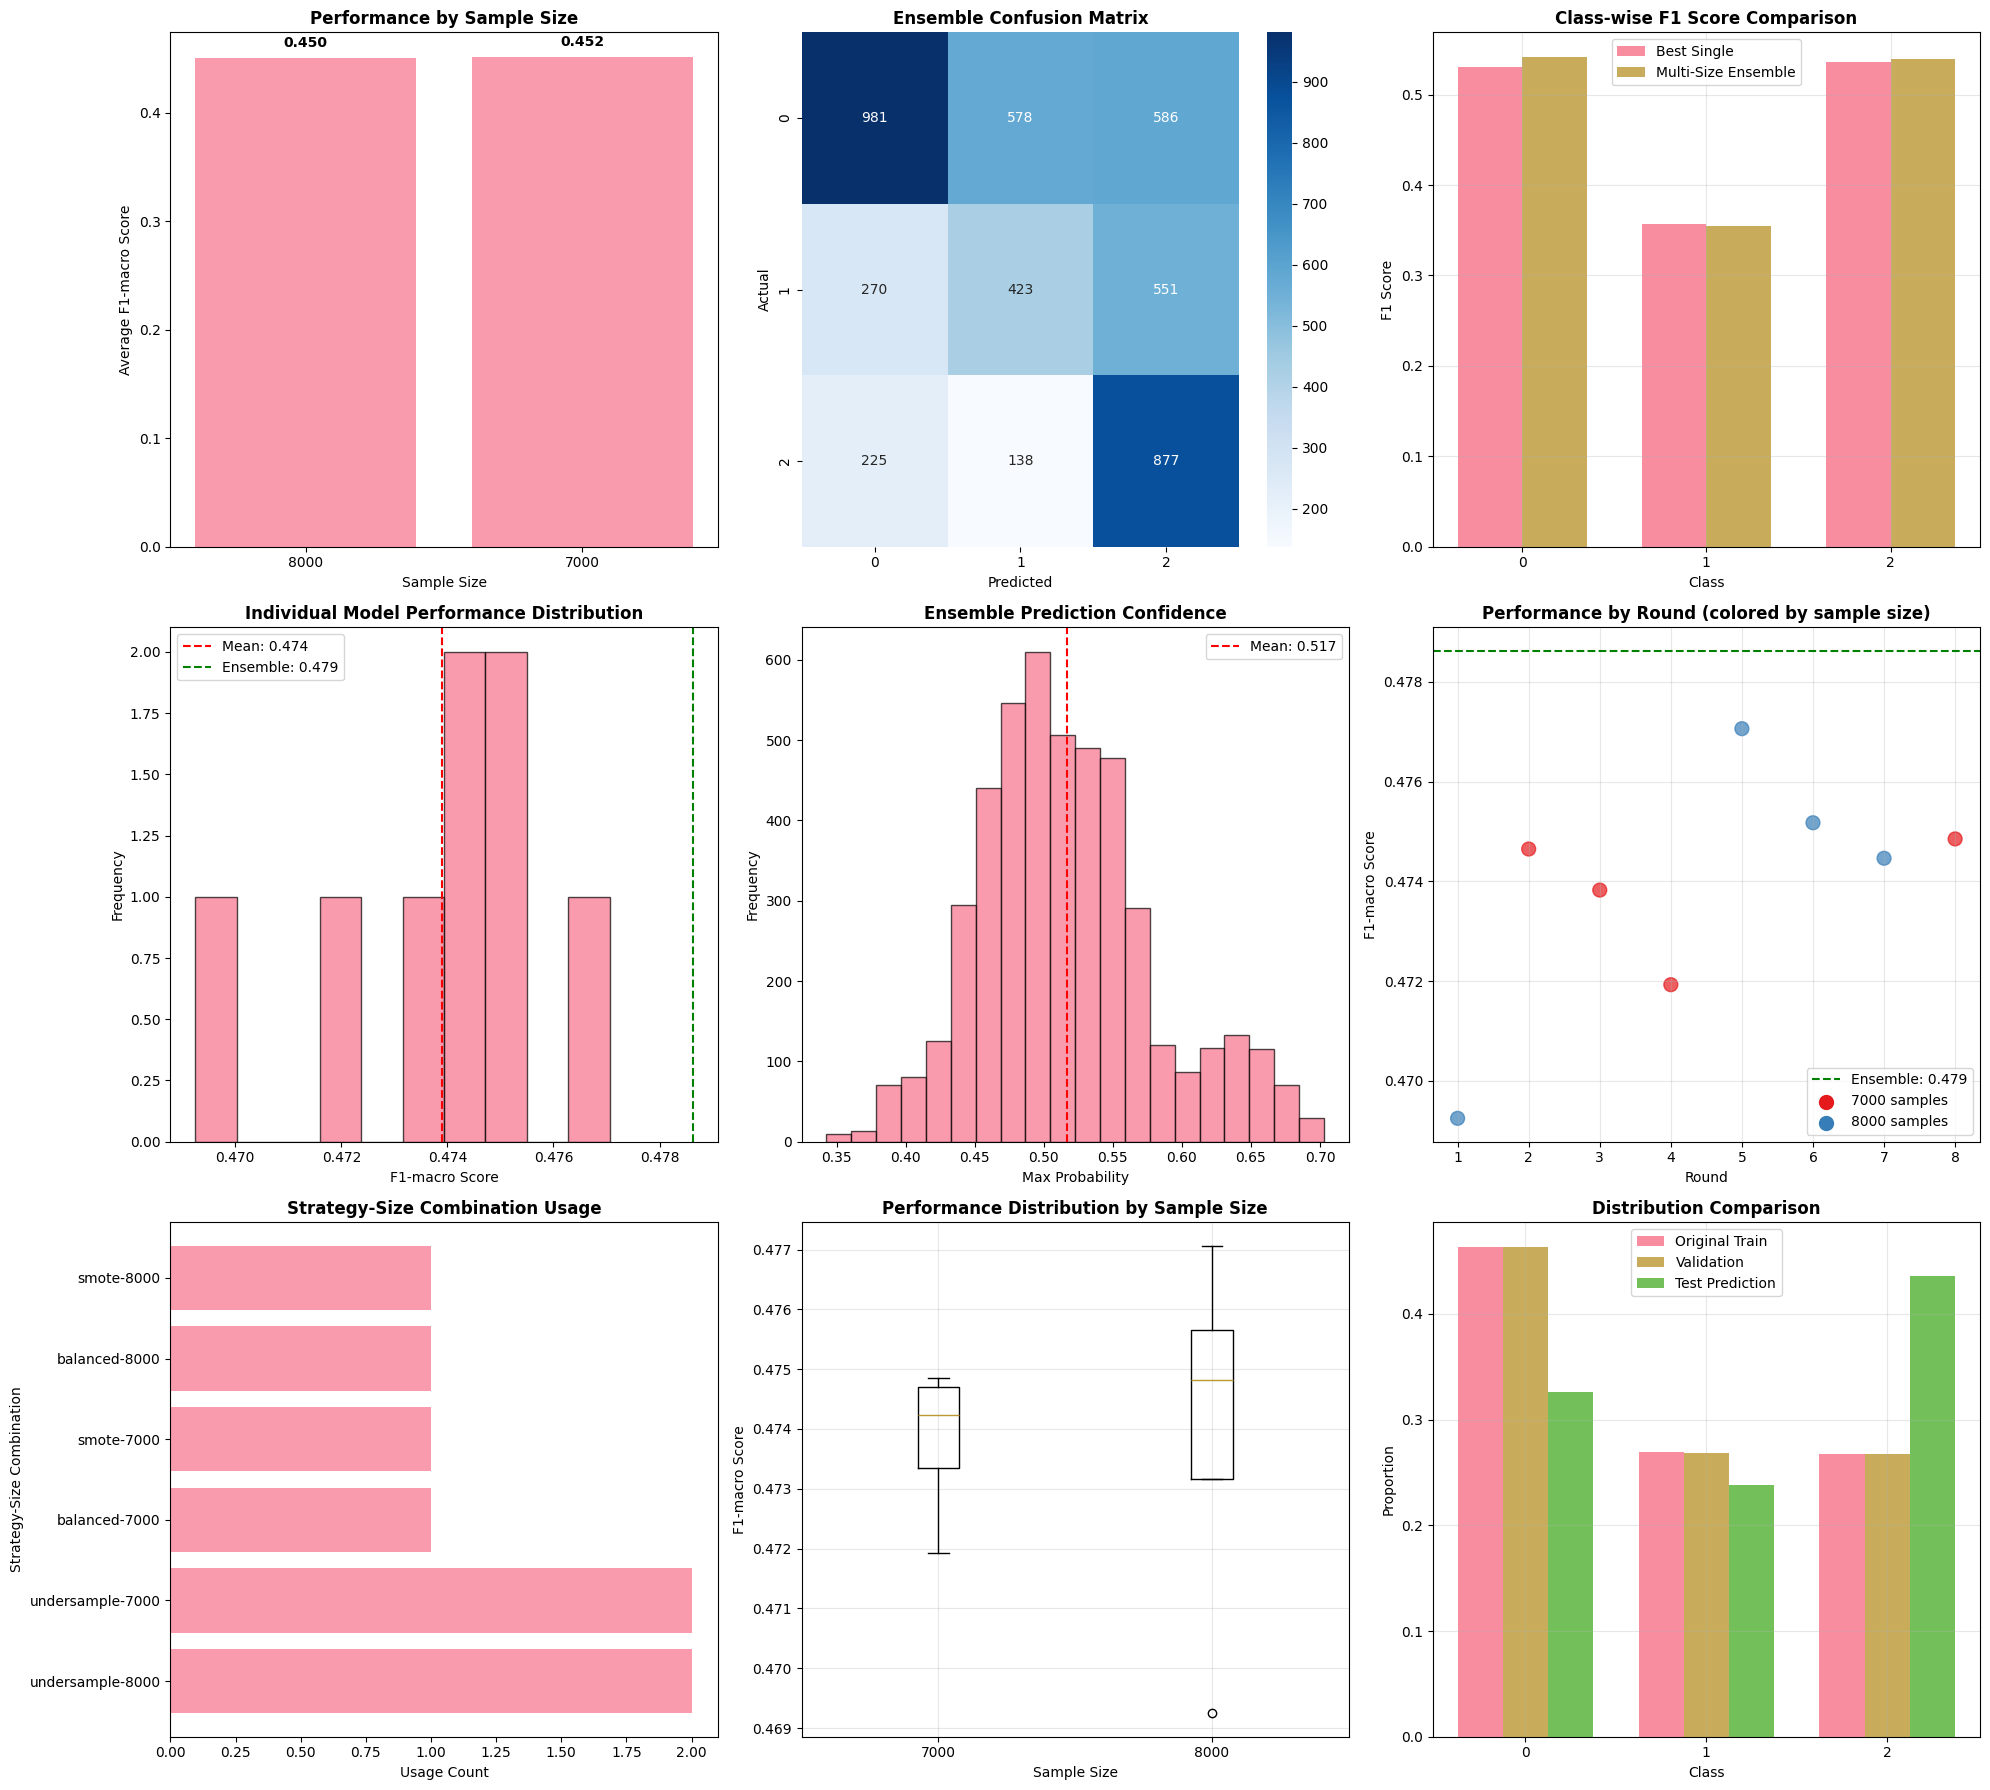


7. 최종 테스트 예측 저장...
Multi-Size Bagging 앙상블 제출 파일 저장: submission_multi_size_bagging_ensemble.csv

테스트 예측 분포: {np.int64(2): 5766, np.int64(1): 3152, np.int64(0): 4307}
테스트 예측 비율: {np.int64(0): 0.3256710775047259, np.int64(1): 0.23833648393194706, np.int64(2): 0.43599243856332703}

Enhanced Bagging 앙상블 최종 성능 요약
최고 단일 전략 (balanced): F1-macro = 0.4754
Enhanced Bagging 앙상블: F1-macro = 0.4786
성능 개선: 0.0032 (+0.67%)

클래스별 성능 개선:
  클래스 0: 0.5400 → 0.5418 (+0.0019)
  클래스 1: 0.3548 → 0.3550 (+0.0003)
  클래스 2: 0.5316 → 0.5390 (+0.0075)

앙상블 구성:
  총 모델 수: 8
  Bagging 비율: 0.85
  샘플 크기: 10000
  사용된 전략: ['balanced', 'smote', 'undersample']

개별 모델 성능 통계:
  평균: 0.4739 (±0.0022)
  최고: 0.4771
  최저: 0.4692

8. 추가 개선 방안:
1. 동적 앙상블 가중치: 개별 모델 성능에 따른 가중 평균
2. 다단계 앙상블: 전략별 앙상블 → 메타 앙상블
3. 적응적 샘플링: 검증 성능에 따른 샘플링 전략 조정
4. 특성 중요도 기반 샘플링: 모델별로 다른 특성 조합 사용
5. 시간적 앙상블: 학습 과정의 다른 시점에서 모델 저장
6. 온도 스케일링: 확률 보정을 통한 신뢰도 개선

프로그램 완료!


31971

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tabpfn import TabPFNClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
import warnings
import gc
warnings.filterwarnings('ignore')

# 시각화 설정
plt.style.use('default')
sns.set_palette("husl")

print("=== TabPFN v2 Enhanced Sampling Ensemble with Bagging ===\n")

# 1. 데이터 로드
print("1. 데이터 로딩...")
train = pd.read_csv("df.csv")
test = pd.read_csv("test_prep.csv")

print(f"Train 데이터 크기: {train.shape}")
print(f"Test 데이터 크기: {test.shape}")

X = train.drop(columns=["support_needs"])
y = train["support_needs"]

# 타겟 변수 레이블 인코딩
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = [str(cls) for cls in le.classes_]

print(f"클래스 분포: {Counter(y_encoded)}")
print(f"클래스 비율: {dict(zip(class_names, np.bincount(y_encoded) / len(y_encoded)))}")

# 검증 세트 분할 (전체 데이터에서)
X_temp, X_val, y_temp, y_val = train_test_split(
    X, y_encoded,
    stratify=y_encoded,
    test_size=0.15,  # 검증용으로 15% 할당
    random_state=42
)

print(f"학습용 데이터: {X_temp.shape[0]}개")
print(f"검증용 데이터: {X_val.shape[0]}개")

# 2. 다양한 샘플링 전략 정의 (v2 방식 유지)
def create_balanced_sample(X, y, sample_size=10000, strategy='balanced', random_state=42):
    """
    다양한 전략으로 균형잡힌 샘플 생성

    strategy:
    - 'balanced': 각 클래스를 동일하게 샘플링
    - 'weighted': 클래스 비율을 조정하되 완전히 균등하지는 않게
    - 'smote': SMOTE 오버샘플링 적용
    - 'undersample': 다수 클래스 언더샘플링
    - 'stratified': 원본 비율을 유지하되 샘플 크기만 줄임
    """
    np.random.seed(random_state)

    if strategy == 'balanced':
        # 각 클래스를 동일하게 샘플링
        samples_per_class = sample_size // len(np.unique(y))

        balanced_indices = []
        for cls in np.unique(y):
            cls_indices = np.where(y == cls)[0]
            if len(cls_indices) >= samples_per_class:
                sampled_indices = np.random.choice(cls_indices, samples_per_class, replace=False)
            else:
                # 클래스 샘플이 부족하면 복원 추출
                sampled_indices = np.random.choice(cls_indices, samples_per_class, replace=True)
            balanced_indices.extend(sampled_indices)

        balanced_indices = np.array(balanced_indices)
        return X.iloc[balanced_indices], y[balanced_indices]

    elif strategy == 'weighted':
        # 클래스 0: 40%, 클래스 1: 35%, 클래스 2: 25% 비율로 조정
        target_ratios = {0: 0.4, 1: 0.35, 2: 0.25}

        weighted_indices = []
        for cls, ratio in target_ratios.items():
            target_count = int(sample_size * ratio)
            cls_indices = np.where(y == cls)[0]
            if len(cls_indices) >= target_count:
                sampled_indices = np.random.choice(cls_indices, target_count, replace=False)
            else:
                sampled_indices = np.random.choice(cls_indices, target_count, replace=True)
            weighted_indices.extend(sampled_indices)

        weighted_indices = np.array(weighted_indices)
        return X.iloc[weighted_indices], y[weighted_indices]

    elif strategy == 'smote':
        # 원본에서 일정 크기 샘플링 후 SMOTE 적용
        if len(y) > sample_size * 0.7:
            sample_indices = np.random.choice(len(y), int(sample_size * 0.7), replace=False)
            X_sample = X.iloc[sample_indices]
            y_sample = y[sample_indices]
        else:
            X_sample, y_sample = X, y

        smote = SMOTE(random_state=random_state, k_neighbors=3)
        try:
            X_resampled, y_resampled = smote.fit_resample(X_sample, y_sample)
            # 샘플 크기 조정
            if len(y_resampled) > sample_size:
                indices = np.random.choice(len(y_resampled), sample_size, replace=False)
                X_resampled = X_resampled.iloc[indices] if hasattr(X_resampled, 'iloc') else pd.DataFrame(X_resampled).iloc[indices]
                y_resampled = y_resampled[indices]
            return X_resampled, y_resampled
        except:
            # SMOTE 실패시 balanced 전략으로 폴백
            return create_balanced_sample(X, y, sample_size, 'balanced', random_state)

    elif strategy == 'undersample':
        # 다수 클래스 언더샘플링
        undersampler = RandomUnderSampler(random_state=random_state)
        try:
            X_resampled, y_resampled = undersampler.fit_resample(X, y)
            # 샘플 크기 조정
            if len(y_resampled) > sample_size:
                indices = np.random.choice(len(y_resampled), sample_size, replace=False)
                X_resampled = X_resampled.iloc[indices] if hasattr(X_resampled, 'iloc') else pd.DataFrame(X_resampled).iloc[indices]
                y_resampled = y_resampled[indices]
            elif len(y_resampled) < sample_size:
                # 부족하면 복원 추출로 보충
                additional_needed = sample_size - len(y_resampled)
                additional_indices = np.random.choice(len(y_resampled), additional_needed, replace=True)
                if hasattr(X_resampled, 'iloc'):
                    X_additional = X_resampled.iloc[additional_indices]
                    X_resampled = pd.concat([X_resampled, X_additional])
                else:
                    X_resampled = pd.DataFrame(X_resampled)
                    X_additional = X_resampled.iloc[additional_indices]
                    X_resampled = pd.concat([X_resampled, X_additional])
                y_resampled = np.concatenate([y_resampled, y_resampled[additional_indices]])

            return X_resampled, y_resampled
        except:
            return create_balanced_sample(X, y, sample_size, 'balanced', random_state)

    elif strategy == 'stratified':
        # 원본 비율 유지하며 샘플링
        if len(y) <= sample_size:
            return X, y

        # 계층화 샘플링
        sss = StratifiedShuffleSplit(n_splits=1, train_size=sample_size, random_state=random_state)
        train_idx, _ = next(sss.split(X, y))
        return X.iloc[train_idx], y[train_idx]

    else:
        raise ValueError(f"Unknown strategy: {strategy}")

# 3. 샘플링 전략별 성능 테스트 (v2 방식 유지)
print("\n2. 다양한 샘플링 전략 테스트...")

strategies = ['balanced', 'weighted', 'smote', 'undersample', 'stratified']
strategy_results = {}

# 다양한 샘플 크기 테스트
sample_sizes = [7000, 8000]  # 7-8천개 범위로 테스트
print(f"테스트할 샘플 크기: {sample_sizes}")

# 샘플 크기별로 전략 테스트
all_strategy_results = {}

for sample_size in sample_sizes:
    print(f"\n=== 샘플 크기 {sample_size}개로 전략 테스트 ===")
    size_strategy_results = {}

    for strategy in strategies:
        print(f"\n--- {strategy.upper()} 전략 테스트 (샘플: {sample_size}) ---")

        try:
            # 샘플링
            X_sample, y_sample = create_balanced_sample(X_temp, y_temp, sample_size, strategy, random_state=42)

            print(f"샘플 크기: {len(y_sample)}")
            sample_dist = Counter(y_sample)
            print(f"클래스 분포: {dict(sample_dist)}")
            print(f"클래스 비율: {dict(zip(class_names, [sample_dist[i]/len(y_sample) for i in range(len(class_names))]))}")

            # TabPFN 모델 학습
            clf = TabPFNClassifier(device="cuda", ignore_pretraining_limits=True)
            clf.fit(X_sample, y_sample)

            # 검증
            y_pred = clf.predict(X_val)
            f1_macro = f1_score(y_val, y_pred, average="macro")
            f1_per_class = f1_score(y_val, y_pred, average=None)

            print(f"F1-macro: {f1_macro:.4f}")
            print(f"클래스별 F1: {dict(zip(class_names, f1_per_class))}")

            size_strategy_results[strategy] = {
                'f1_macro': f1_macro,
                'f1_per_class': f1_per_class,
                'sample_dist': sample_dist,
                'sample_size': sample_size
            }

            # 메모리 정리
            del clf
            gc.collect()

        except Exception as e:
            print(f"에러 발생: {e}")
            size_strategy_results[strategy] = None

    all_strategy_results[sample_size] = size_strategy_results

# 전체 결과 통합 및 최고 성능 조합 찾기
print(f"\n=== 샘플 크기별 전략 성능 종합 ===")
best_combinations = []

for sample_size, size_results in all_strategy_results.items():
    valid_results = {k: v for k, v in size_results.items() if v is not None}
    if valid_results:
        sorted_results = sorted(valid_results.items(), key=lambda x: x[1]['f1_macro'], reverse=True)
        print(f"\n샘플 크기 {sample_size}:")
        for i, (strategy, result) in enumerate(sorted_results):
            print(f"  {i+1}. {strategy}: F1-macro = {result['f1_macro']:.4f}")
            best_combinations.append({
                'sample_size': sample_size,
                'strategy': strategy,
                'f1_macro': result['f1_macro'],
                'f1_per_class': result['f1_per_class'],
                'sample_dist': result['sample_dist']
            })

# 전체 조합에서 상위 성능 선택
best_combinations = sorted(best_combinations, key=lambda x: x['f1_macro'], reverse=True)
print(f"\n=== 전체 최고 성능 조합 TOP 6 ===")
for i, combo in enumerate(best_combinations[:6]):
    print(f"{i+1}. {combo['strategy']} (샘플:{combo['sample_size']}) = F1: {combo['f1_macro']:.4f}")

# 상위 6개 조합을 앙상블에 사용
top_combinations = best_combinations[:6]
print(f"\n앙상블에 사용할 조합: {[(c['strategy'], c['sample_size']) for c in top_combinations]}")

# 4. 최고 성능 조합들 선택 (샘플 크기 + 전략)
print("\n3. 상위 조합들 선택 완료...")

# 5. [NEW] 다양한 샘플 크기를 활용한 Bagging 앙상블 구성
print("\n4. 다양한 샘플 크기 Bagging 앙상블 학습...")

N_ENSEMBLE = 8        # 앙상블 라운드 수 (상위 6개 조합을 활용하기 위해 8로 증가)
BAG_FRACTION = 0.85   # 각 라운드에서 사용할 훈련 데이터 비율

ensemble_val_probas = []
ensemble_test_probas = []
ensemble_info = []

# 각 조합을 순환하면서 앙상블 구성
for round_idx in range(N_ENSEMBLE):
    combo = top_combinations[round_idx % len(top_combinations)]  # 조합을 순환 사용
    strategy = combo['strategy']
    sample_size = combo['sample_size']
    random_seed = 42 + round_idx

    print(f"\n[앙상블 라운드 {round_idx+1}/{N_ENSEMBLE}] Strategy: {strategy}, Sample Size: {sample_size}, Seed: {random_seed}")

    try:
        # 1) Bagging: 훈련 데이터의 일부를 계층 샘플링으로 선택
        sss = StratifiedShuffleSplit(n_splits=1, train_size=BAG_FRACTION, random_state=random_seed)
        bag_idx, _ = next(sss.split(X_temp, y_temp))
        X_bag = X_temp.iloc[bag_idx]
        y_bag = y_temp[bag_idx]

        print(f"  Bagging 후 데이터 크기: {len(y_bag)}")
        print(f"  Bagging 클래스 분포: {Counter(y_bag)}")

        # 2) 선택된 전략과 샘플 크기로 샘플링
        X_sample, y_sample = create_balanced_sample(
            X_bag, y_bag, sample_size, strategy, random_state=random_seed
        )

        sample_dist = Counter(y_sample)
        print(f"  샘플링 후 크기: {len(y_sample)}")
        print(f"  샘플링 후 클래스 분포: {dict(sample_dist)}")

        # 3) TabPFN 모델 학습
        clf = TabPFNClassifier(device="cuda", ignore_pretraining_limits=True)
        clf.fit(X_sample, y_sample)

        # 4) 검증 및 테스트 예측 확률 저장
        val_proba = clf.predict_proba(X_val)
        test_proba = clf.predict_proba(test)

        ensemble_val_probas.append(val_proba)
        ensemble_test_probas.append(test_proba)

        # 5) 개별 모델 성능 기록
        val_pred = np.argmax(val_proba, axis=1)
        f1_macro = f1_score(y_val, val_pred, average="macro")

        ensemble_info.append({
            'round': round_idx + 1,
            'strategy': strategy,
            'sample_size': sample_size,
            'seed': random_seed,
            'f1_macro': f1_macro,
            'sample_dist': sample_dist,
            'bag_size': len(y_bag),
            'final_size': len(y_sample)
        })

        print(f"  개별 모델 F1-macro: {f1_macro:.4f}")

        # 메모리 정리
        del clf
        gc.collect()

    except Exception as e:
        print(f"  라운드 {round_idx+1} 실패: {e}")
        continue

print(f"\n성공적으로 구성된 앙상블 모델 수: {len(ensemble_val_probas)}")

# 6. 앙상블 예측 및 평가
if len(ensemble_val_probas) > 0:
    print("\n5. 앙상블 예측 및 성능 평가...")

    # Soft Voting: 확률 평균
    ensemble_val_proba_avg = np.mean(ensemble_val_probas, axis=0)
    ensemble_test_proba_avg = np.mean(ensemble_test_probas, axis=0)

    # 최종 예측
    ensemble_val_pred = np.argmax(ensemble_val_proba_avg, axis=1)
    ensemble_test_pred = np.argmax(ensemble_test_proba_avg, axis=1)

    # 앙상블 성능 평가
    f1_ensemble = f1_score(y_val, ensemble_val_pred, average="macro")
    f1_ensemble_per_class = f1_score(y_val, ensemble_val_pred, average=None)

    print(f"앙상블 F1-macro: {f1_ensemble:.4f}")
    print(f"앙상블 클래스별 F1: {dict(zip(class_names, f1_ensemble_per_class))}")

    # 개별 모델 성능 통계
    individual_scores = [info['f1_macro'] for info in ensemble_info]
    print(f"개별 모델 평균 성능: {np.mean(individual_scores):.4f} (±{np.std(individual_scores):.4f})")
    print(f"최고 개별 모델: {max(individual_scores):.4f}")
    print(f"최저 개별 모델: {min(individual_scores):.4f}")

    # 7. 상세 분석 및 시각화 (v2 스타일 유지)
    print("\n6. 상세 분석 및 시각화...")

    # 분류 리포트
    print("\n앙상블 분류 리포트:")
    print(classification_report(y_val, ensemble_val_pred, target_names=class_names, digits=4))

    # 시각화
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))

    # (1) 샘플 크기별 전략 성능 비교
    sample_size_performance = {}
    for combo in best_combinations[:10]:  # 상위 10개
        size = combo['sample_size']
        if size not in sample_size_performance:
            sample_size_performance[size] = []
        sample_size_performance[size].append(combo['f1_macro'])

    sizes = list(sample_size_performance.keys())
    avg_scores = [np.mean(sample_size_performance[size]) for size in sizes]

    axes[0, 0].bar([str(size) for size in sizes], avg_scores, alpha=0.7)
    axes[0, 0].set_title('Performance by Sample Size', fontweight='bold')
    axes[0, 0].set_ylabel('Average F1-macro Score')
    axes[0, 0].set_xlabel('Sample Size')
    for i, (size, score) in enumerate(zip(sizes, avg_scores)):
        axes[0, 0].text(i, score + 0.01, f'{score:.3f}', ha='center', fontweight='bold')

    # (2) 앙상블 혼동 행렬
    cm = confusion_matrix(y_val, ensemble_val_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1],
                xticklabels=class_names, yticklabels=class_names)
    axes[0, 1].set_title('Ensemble Confusion Matrix', fontweight='bold')
    axes[0, 1].set_xlabel('Predicted')
    axes[0, 1].set_ylabel('Actual')

    # (3) 클래스별 F1 스코어 비교 (최고 단일 vs 앙상블)
    best_single_f1 = best_combinations[0]['f1_per_class']

    x_pos = np.arange(len(class_names))
    width = 0.35
    axes[0, 2].bar(x_pos - width/2, best_single_f1, width, label='Best Single', alpha=0.8)
    axes[0, 2].bar(x_pos + width/2, f1_ensemble_per_class, width, label='Multi-Size Ensemble', alpha=0.8)
    axes[0, 2].set_title('Class-wise F1 Score Comparison', fontweight='bold')
    axes[0, 2].set_xlabel('Class')
    axes[0, 2].set_ylabel('F1 Score')
    axes[0, 2].set_xticks(x_pos)
    axes[0, 2].set_xticklabels(class_names)
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # (4) 개별 모델 성능 분포
    axes[1, 0].hist(individual_scores, bins=10, alpha=0.7, edgecolor='black')
    axes[1, 0].axvline(np.mean(individual_scores), color='red', linestyle='--',
                      label=f'Mean: {np.mean(individual_scores):.3f}')
    axes[1, 0].axvline(f1_ensemble, color='green', linestyle='--',
                      label=f'Ensemble: {f1_ensemble:.3f}')
    axes[1, 0].set_title('Individual Model Performance Distribution', fontweight='bold')
    axes[1, 0].set_xlabel('F1-macro Score')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()

    # (5) 앙상블 예측 확신도 분포
    max_proba = np.max(ensemble_val_proba_avg, axis=1)
    axes[1, 1].hist(max_proba, bins=20, alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Ensemble Prediction Confidence', fontweight='bold')
    axes[1, 1].set_xlabel('Max Probability')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].axvline(np.mean(max_proba), color='red', linestyle='--',
                      label=f'Mean: {np.mean(max_proba):.3f}')
    axes[1, 1].legend()

    # (6) 라운드별 성능 추이 (샘플 크기별 색상 구분)
    rounds = [info['round'] for info in ensemble_info]
    round_scores = [info['f1_macro'] for info in ensemble_info]
    round_sample_sizes = [info['sample_size'] for info in ensemble_info]

    # 샘플 크기별 색상 매핑
    unique_sizes = sorted(list(set(round_sample_sizes)))
    size_colors = {size: plt.cm.Set1(i) for i, size in enumerate(unique_sizes)}
    colors = [size_colors[size] for size in round_sample_sizes]

    scatter = axes[1, 2].scatter(rounds, round_scores, c=colors, s=100, alpha=0.7)
    axes[1, 2].axhline(f1_ensemble, color='green', linestyle='--', label=f'Ensemble: {f1_ensemble:.3f}')
    axes[1, 2].set_title('Performance by Round (colored by sample size)', fontweight='bold')
    axes[1, 2].set_xlabel('Round')
    axes[1, 2].set_ylabel('F1-macro Score')
    axes[1, 2].grid(True, alpha=0.3)

    # 범례 추가 (샘플 크기별)
    for size, color in size_colors.items():
        axes[1, 2].scatter([], [], c=[color], label=f'{size} samples', s=100)
    axes[1, 2].legend()

    # (7) 전략 + 샘플 크기 조합별 사용 빈도
    combination_usage = Counter([f"{info['strategy']}-{info['sample_size']}" for info in ensemble_info])
    combo_names = list(combination_usage.keys())
    combo_counts = list(combination_usage.values())

    axes[2, 0].barh(combo_names, combo_counts, alpha=0.7)
    axes[2, 0].set_title('Strategy-Size Combination Usage', fontweight='bold')
    axes[2, 0].set_xlabel('Usage Count')
    axes[2, 0].set_ylabel('Strategy-Size Combination')

    # (8) 샘플 크기별 성능 분포
    size_performance_dist = {}
    for info in ensemble_info:
        size = info['sample_size']
        if size not in size_performance_dist:
            size_performance_dist[size] = []
        size_performance_dist[size].append(info['f1_macro'])

    # 박스플롯으로 표시
    size_labels = []
    size_scores_list = []
    for size in sorted(size_performance_dist.keys()):
        size_labels.append(f"{size}")
        size_scores_list.append(size_performance_dist[size])

    axes[2, 1].boxplot(size_scores_list, labels=size_labels)
    axes[2, 1].set_title('Performance Distribution by Sample Size', fontweight='bold')
    axes[2, 1].set_xlabel('Sample Size')
    axes[2, 1].set_ylabel('F1-macro Score')
    axes[2, 1].grid(True, alpha=0.3)

    # (9) 예측 분포 비교
    original_dist = np.bincount(y_temp) / len(y_temp)
    val_dist = np.bincount(y_val) / len(y_val)
    test_pred_dist = np.bincount(ensemble_test_pred) / len(ensemble_test_pred)

    x_pos = np.arange(len(class_names))
    width = 0.25
    axes[2, 2].bar(x_pos - width, original_dist, width, label='Original Train', alpha=0.8)
    axes[2, 2].bar(x_pos, val_dist, width, label='Validation', alpha=0.8)
    axes[2, 2].bar(x_pos + width, test_pred_dist, width, label='Test Prediction', alpha=0.8)
    axes[2, 2].set_title('Distribution Comparison', fontweight='bold')
    axes[2, 2].set_xlabel('Class')
    axes[2, 2].set_ylabel('Proportion')
    axes[2, 2].set_xticks(x_pos)
    axes[2, 2].set_xticklabels(class_names)
    axes[2, 2].legend()
    axes[2, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 8. 테스트 예측 저장
    print("\n7. 최종 테스트 예측 저장...")

    # 원래 레이블로 변환
    test_pred_decoded = le.inverse_transform(ensemble_test_pred)

    # 제출 파일 생성
    sub = pd.DataFrame({
        "id": [f"TEST_{i:05d}" for i in range(len(test_pred_decoded))],
        "support_needs": test_pred_decoded,
        "prob_class_0": ensemble_test_proba_avg[:, 0],
        "prob_class_1": ensemble_test_proba_avg[:, 1],
        "prob_class_2": ensemble_test_proba_avg[:, 2]
    })
    sub.to_csv("submission_multi_size_bagging_ensemble.csv", index=False)
    print("Multi-Size Bagging 앙상블 제출 파일 저장: submission_multi_size_bagging_ensemble.csv")

    # 테스트 예측 분포 확인
    test_pred_dist = Counter(test_pred_decoded)
    print(f"\n테스트 예측 분포: {dict(test_pred_dist)}")
    print(f"테스트 예측 비율: {dict(zip(le.classes_, [test_pred_dist[cls]/len(test_pred_decoded) for cls in le.classes_]))}")

    # 9. 최종 성능 요약
    print("\n" + "="*70)
    print("Enhanced Bagging 앙상블 최종 성능 요약")
    print("="*70)

    print(f"최고 단일 전략 ({sorted_strategies[0][0]}): F1-macro = {sorted_strategies[0][1]['f1_macro']:.4f}")
    print(f"Enhanced Bagging 앙상블: F1-macro = {f1_ensemble:.4f}")
    improvement = f1_ensemble - sorted_strategies[0][1]['f1_macro']
    print(f"성능 개선: {improvement:.4f} ({improvement/sorted_strategies[0][1]['f1_macro']*100:+.2f}%)")

    print(f"\n클래스별 성능 개선:")
    for i, class_name in enumerate(class_names):
        single_f1 = sorted_strategies[0][1]['f1_per_class'][i]
        ensemble_f1 = f1_ensemble_per_class[i]
        improvement = ensemble_f1 - single_f1
        print(f"  클래스 {class_name}: {single_f1:.4f} → {ensemble_f1:.4f} ({improvement:+.4f})")

    print(f"\n앙상블 구성:")
    print(f"  총 모델 수: {len(ensemble_val_probas)}")
    print(f"  Bagging 비율: {BAG_FRACTION}")
    print(f"  샘플 크기: {SAMPLE_SIZE}")
    print(f"  사용된 전략: {top_strategies}")

    print(f"\n개별 모델 성능 통계:")
    print(f"  평균: {np.mean(individual_scores):.4f} (±{np.std(individual_scores):.4f})")
    print(f"  최고: {max(individual_scores):.4f}")
    print(f"  최저: {min(individual_scores):.4f}")
    print("="*70)

    # 10. 추가 개선 방안 제시
    print("\n8. 추가 개선 방안:")
    print("1. 동적 앙상블 가중치: 개별 모델 성능에 따른 가중 평균")
    print("2. 다단계 앙상블: 전략별 앙상블 → 메타 앙상블")
    print("3. 적응적 샘플링: 검증 성능에 따른 샘플링 전략 조정")
    print("4. 특성 중요도 기반 샘플링: 모델별로 다른 특성 조합 사용")
    print("5. 시간적 앙상블: 학습 과정의 다른 시점에서 모델 저장")
    print("6. 온도 스케일링: 확률 보정을 통한 신뢰도 개선")

else:
    print("❌ 앙상블 구성 실패 - 유효한 모델이 없습니다.")

    # 대안: 기본 단일 모델 예측
    print("\n대안으로 최고 성능 단일 전략 사용...")
    best_strategy = sorted_strategies[0][0]

    X_sample, y_sample = create_balanced_sample(X_temp, y_temp, sample_size, best_strategy, random_state=42)

    clf = TabPFNClassifier(device="cuda", ignore_pretraining_limits=True)
    clf.fit(X_sample, y_sample)

    # 테스트 예측
    test_pred = clf.predict(test)
    test_pred_decoded = le.inverse_transform(test_pred)

    # 제출 파일 생성
    sub = pd.DataFrame({
        "id": [f"TEST_{i:05d}" for i in range(len(test_pred_decoded))],
        "support_needs": test_pred_decoded
    })
    sub.to_csv("submission_single_best.csv", index=False)
    print(f"단일 모델 ({best_strategy}) 제출 파일 저장: submission_single_best.csv")

print("\n프로그램 완료!")

# 메모리 정리
gc.collect()